In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Convenience for making pretty plots
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [ ]:
from gpax.kernels import RBFKernel
from gpax.gp import ExactGP, VariationalInferenceGP
from gpax.experiments import SimpleSinusoidal1d
from gpax.state import set_rng_key

# Simple plotting utility

In [32]:
def make_simple_gp_plot(ax, gp, x, y, x_grid):

    mu, sd = gp.predict(x_grid)
    ci = [mu - 2.0 * sd, mu + 2.0 * sd]  # 95% confidence interval

    plot_kwargs = {
        'linewidth': 0.0,
        'marker': 's',
        'ms': 1.0,
        'capthick': 0.3,
        'capsize': 2.0,
        'elinewidth': 0.3
    }
    
    ax.errorbar(x, y, yerr=gp.y_std if gp.y_std is not None else None, color="black", zorder=3, **plot_kwargs, label="Observations")
    ax.plot(x_grid, mu, "r-", label=r"$\mu(x)$")
    ax.fill_between(x_grid.squeeze(), *ci, color="red", alpha=0.5, linewidth=0, zorder=3, label=r"$\mu(x) \pm 2\sigma(x)$")


# Set the experiment data and key

GPax handles random state in the same way the `random` or `numpy` libraries do. You can seed the "global" random number generator, which applies to all GPax functions via `gpax.state.set_rng_key`.

In [4]:
set_rng_key(1)

The `Experiment` abstraction is a utility for getting dummy data used for testing and demonstration. In the cell below, we use the `SimpleSinusoidal1d` dataset, which is, exactly as it sounds like, a simple sinusoidal function in one dimension. We get a default "training" dataset, then a grid of dense coordinates, with 100 points per dimension (`ppd`), where in this case there is just a single dimension.

In [5]:
experiment = SimpleSinusoidal1d()
x, y = experiment.default_dataset()
x_grid = experiment.get_dense_coordinates(ppd=100)

# Exact (fully Bayesian) Gaussian Process

The `ExactGP` object is a fully Bayesian implementation of a Gaussian Process. At minimum, it takes a kernel object during instantiation (more on kernels in a later notebook, for now we'll use a simple Radial Basis Function kernel). Training is performed using Markov Chain Monte Carlo (MCMC) via the `numpyro` package. There are three different ways to use every GPax GP:
1. Without data and without fitting (samples drawn from the prior)
2. With data and without fitting (samples drawn from the posterior but without inference)
3. With data and with fitting (samples drawn from the posterior after inference)

Give each of the below a try and see how it changes the result! _Note: only call `fit` on #3!_

There are also three ways to specify observation uncertainty in the form of `y_std`. Essentially, `y_std^2` is the diagonal of the covariance matrix.
1. Providing `y_std=None` allows the GP itself to learn the noise during inference.
2. Providing `y_std=0` forces the GP to have zero noise (perfect interpolant).
3. Providing `y_std>0` forces the GP to have non-zero noise.

_Note: for 2 and 3, if a scalar is provided, that scalar is broadcast to all observations in the training data; if a vector is provided, it must be of the same shape as `y`, and each observation will have that corresponding uncertainty._

After the GP is fit (or not!) it's time to make predictions. There are two ways to do this, `sample` and `predict`. 

1. `sample` produces every sample over the GP for every kernel hyperparameter.
2. `predict` is the simplest method as it provides two simple outputs, the mean and standard deviation of the GP at every point provided to the function.

For now, we will just focus on using `predict`. It's also worth noting that `predict` takes a "fast" keyword argument. If `True`, only the median of the hyper parameters is used (with `gp_samples`, optionally provided at class instantiation, dictating how many samples _per hyper parameter_ are taken from the GP with those hyper parameters). This means a factor of `hp_samples` less hyper parameters are needed to be taken during prediction, which can dramatically speed up the code at prediction time. Note that `fast=False` by default. Give it a try!

Now, **let's see what a few different example plots look like**!

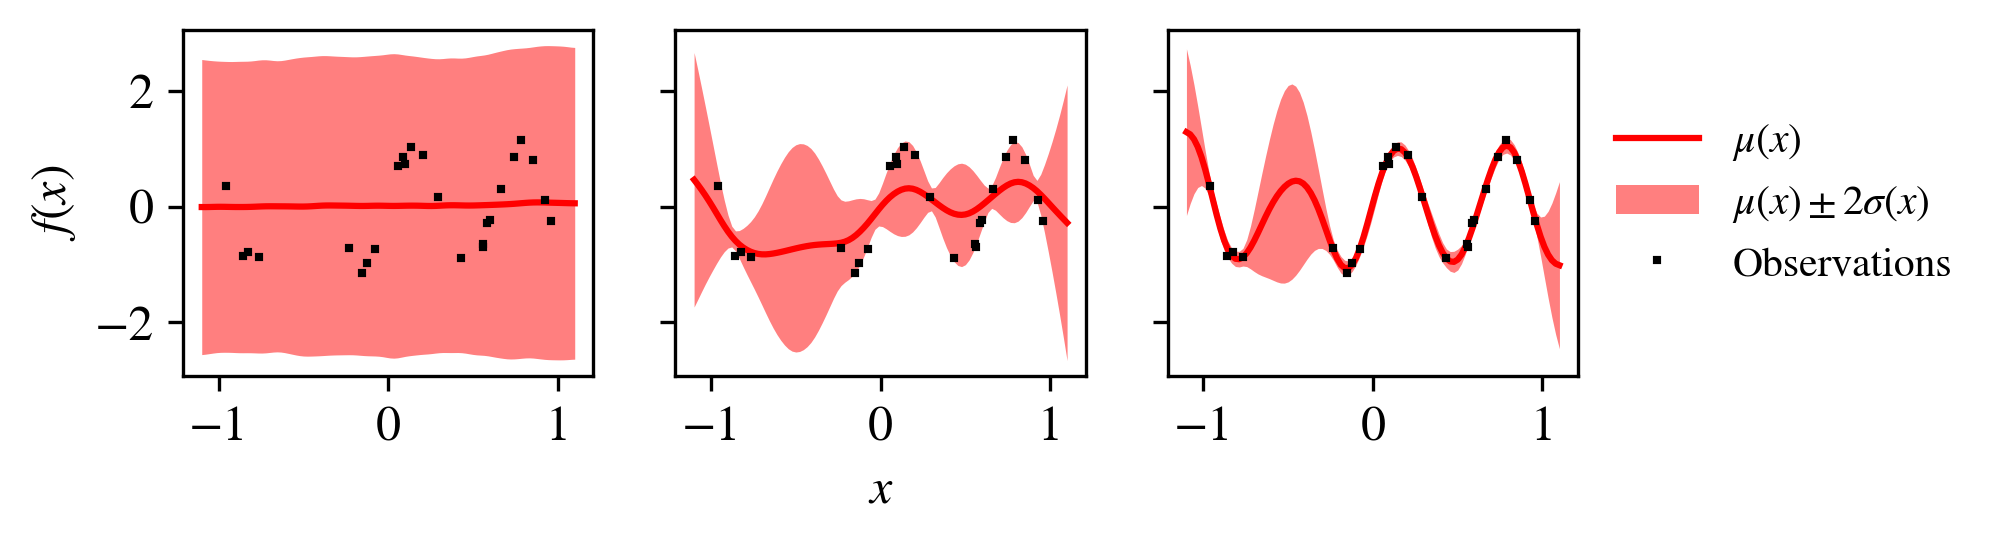

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(6, 1.5), sharey=True)

# No conditioning
gp = ExactGP(kernel=RBFKernel())
ax = axs[0]
make_simple_gp_plot(ax, gp, x, y, x_grid)

# Condition on data, no further GP parameter training
gp = ExactGP(kernel=RBFKernel(), x=x, y=y, y_std=None)
ax = axs[1]
make_simple_gp_plot(ax, gp, x, y, x_grid)

# Condition on data and train using MCMC
gp = ExactGP(kernel=RBFKernel(), x=x, y=y, y_std=None, verbose=0)
gp.fit()
ax = axs[2]
make_simple_gp_plot(ax, gp, x, y, x_grid)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")

# Axes labels
axs[0].set_ylabel(r"$f(x)$")
axs[1].set_xlabel(r"$x$")

plt.show()

**Experiment with everything above, and with different choices for fitting and `y_std` to see how they affect the results!**

# Variational Inference Gaussian Process

The `VariationalInferenceGP` behaves much like the `ExactGP`. In fact, it's API is effectively identical. The primary difference between the Exact GP and a VI GP is that whereas the Exact GP uses Markov Chain Monte Carlo for inference, the VI GP uses gradient descent, treating the hyper parameters of the model as trainable parameter in the same sense as a machine learning model. In fact, the VI GP actually uses automatic differentiation, and as such, the final "trained" model has only one set of "optimal" hyper parameters. VI GP's can be faster, but are less accurate in general, since unlike MCMC, they are not guaranteed to converge to the exact answer.

In [12]:
gp = VariationalInferenceGP(kernel=RBFKernel(), x=x, y=y, y_std=None, num_steps=50000)
gp.fit()

In [13]:
mu, sd = gp.predict(x_grid)
ci = [mu - 2.0 * sd, mu + 2.0 * sd]  # 95% confidence interval

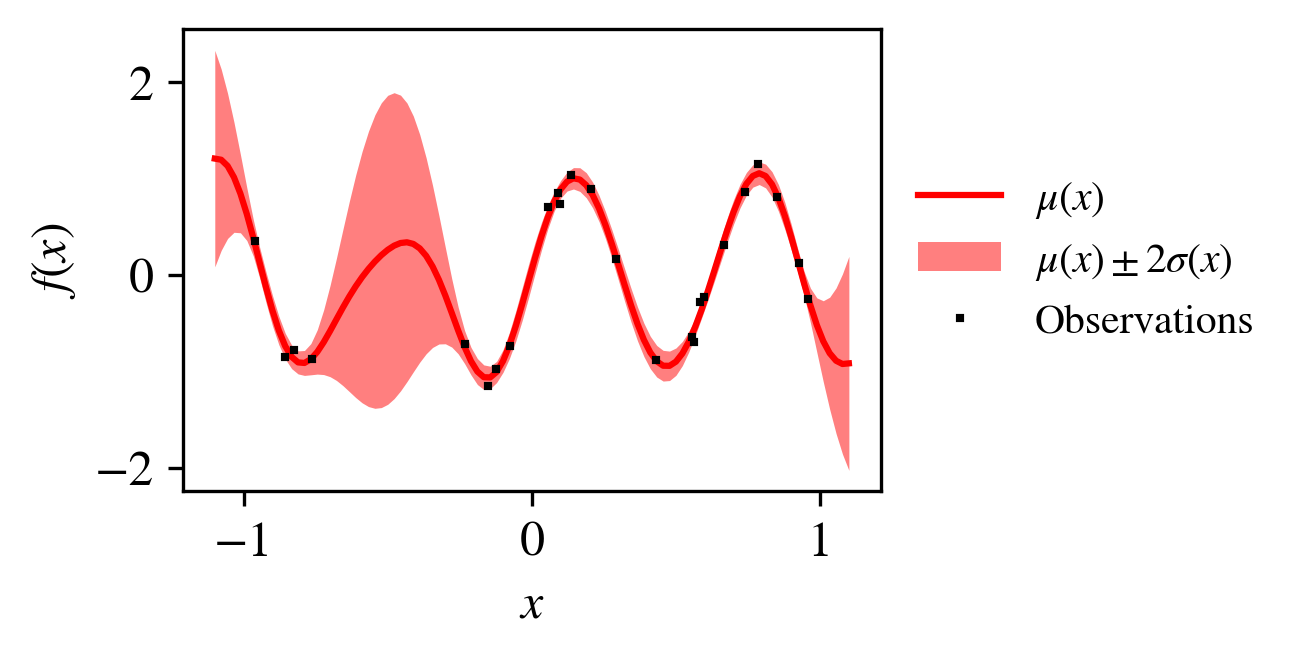

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

plot_kwargs = {
    'linewidth': 0.0,
    'marker': 's',
    'ms': 1.0,
    'capthick': 0.3,
    'capsize': 2.0,
    'elinewidth': 0.3
}

ax.errorbar(x, y, yerr=gp.y_std if gp.y_std is not None else None, color="black", zorder=3, **plot_kwargs, label="Observations")
ax.plot(x_grid, mu, "r-", label=r"$\mu(x)$")
ax.fill_between(x_grid.squeeze(), *ci, color="red", alpha=0.5, linewidth=0, zorder=3, label=r"$\mu(x) \pm 2\sigma(x)$")

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")

plt.show()